In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits

%matplotlib inline

np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Qtd Digits:  1797


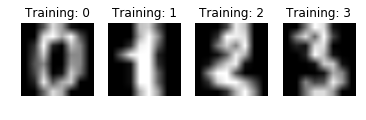

In [2]:
digits = load_digits()
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap='gray', interpolation='bilinear')
    plt.title('Training: %i' % label)

n_samples = len(digits.images)
print('Qtd Digits: ', n_samples)

X = digits.images.reshape((n_samples, -1))
X = X / 255.
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Acurácia: 94.26%
Classification report for classifier 
             precision    recall  f1-score   support

          0       0.98      0.98      0.98        45
          1       0.92      0.90      0.91        52
          2       0.94      0.94      0.94        53
          3       0.93      0.93      0.93        54
          4       1.00      0.98      0.99        48
          5       0.95      0.95      0.95        57
          6       0.97      0.98      0.98        60
          7       0.93      0.98      0.95        53
          8       0.90      0.92      0.91        61
          9       0.93      0.88      0.90        57

avg / total       0.94      0.94      0.94       540


--------------------
Confusion matrix:
[[44  0  0  0  0  0  1  0  0  0]
 [ 0 47  0  0  0  0  1  0  3  1]
 [ 0  1 50  0  0  0  0  0  2  0]
 [ 0  0  3 50  0  1  0  0  0  0]
 [ 0  0  0  0 47  0  0  1  0  0]
 [ 0  0  0  0  0 54  0  0  1  2]
 [ 0  1  0  0  0  0 59  0  0  0]
 [ 0  0  0  0  0  1  0 52  0  0]
 [

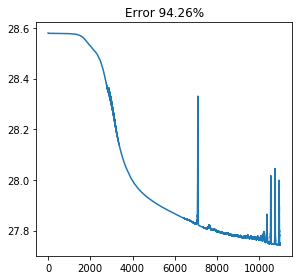

In [3]:
from src.nn import Layer, NeuralNetwork

final_error = []
better_acc = 0

layers = (
    Layer(1, inputs=64, outputs=100, activation='relu'),
    Layer(2, inputs=100, outputs=15, activation='relu'), 
    Layer(3, inputs=15, outputs=10, activation='softmax'), 
)

md = NeuralNetwork(layers, X_train.copy(), y_train.copy(), loss='cross_entropy')
error = md.train(epochs=11000, lr=1e-1)

y_pred = md.predict(X_test.copy())

acc = np.round((np.sum(y_pred == y_test) / len(y_test)) * 100, 2)
if acc > better_acc:
    better_acc = acc
final_error = error
print(f'Acurácia: {acc}%')

print("Classification report for classifier \n%s\n"
      % (classification_report(y_test, y_pred)))
print('-' * 20)
print("Confusion matrix:\n%s" % confusion_matrix(y_test, y_pred))

if len(final_error):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'Error {better_acc}%')
    plt.plot(range(len(final_error)), final_error)
    plt.tight_layout()
    plt.show()

In [4]:
classifier = MLPClassifier(
    max_iter=1500,
    solver='sgd',
    batch_size=X_train.shape[0],
    shuffle=False,
    learning_rate_init=1e-1,
    random_state=0
)
classifier.fit(X_train, y_train)

predicted = classifier.predict(X_test)

print(f'Acurácia: {np.round(classifier.score(X_test, y_test) * 100, 2)}%')
print('-' * 20)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, classification_report(y_test, predicted)))
print('-' * 20)
print("Confusion matrix:\n%s" % confusion_matrix(y_test, predicted))

Acurácia: 95.74%
--------------------
Classification report for classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size=1257, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=1500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=False,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False):
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        45
          1       0.89      0.92      0.91        52
          2       1.00      0.96      0.98        53
          3       0.98      0.93      0.95        54
          4       0.98      0.98      0.98        48
          5       0.95      0.95      0.95        57
          6       0.95      0.98      0.97        60
          7       0.98      0.98      0.98        53
          8       